#Assignment 3 - Fine Tuning a Language Model
##Classify semantic equivalence in sentence pairs.
Following TensorFlow tutorial from https://www.tensorflow.org/text/tutorials/fine_tune_bert

In [1]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.4 MB 5.4 MB/s 


In [2]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 4.7 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 352 kB 37.9 MB/s 
     |████████████████████████████████| 213 kB 34.9 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 1.1 MB 35.1 MB/s 
     |████████████████████████████████| 99 kB 7.9 MB/s 
     |████████████████████████████████| 1.2 MB 34.6 MB/s 


In [3]:
# Imports

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks



## Resources

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

## Get Data

In [6]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete0SJ7UC/glue-train.tfrecord


  0%|          | 0/3668 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete0SJ7UC/glue-validation.tfrecord


  0%|          | 0/408 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete0SJ7UC/glue-test.tfrecord


  0%|          | 0/1725 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [7]:
glue['train']

{'idx': <tf.Tensor: shape=(3668,), dtype=int32, numpy=array([1680, 1456, 3017, ..., 3682, 3619, 3624], dtype=int32)>,
 'label': <tf.Tensor: shape=(3668,), dtype=int64, numpy=array([0, 0, 1, ..., 1, 0, 1])>,
 'sentence1': <tf.Tensor: shape=(3668,), dtype=string, numpy=
 array([b'The identical rovers will act as robotic geologists , searching for evidence of past water .',
        b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed .",
        b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .',
        ...,
        b'Stack said he did no work for Triumph until 1999 , when a grand jury began investigating Silvester .',
        b'The giant rock was first observed on August 24 by Lincoln Near-Earth Asteroid Research Program , based in Socorro , New Mexico .',
        b"Two of Collins ' top assistants will consult with state police during the investigation and determine 

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [9]:
info.features['label'].names

['not_equivalent', 'equivalent']

In [10]:
# Show one example of the training data

glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


## Tokenizer

In [11]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [12]:
tokens = tokenizer.tokenize("Test sentence to tokenize")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['test', 'sentence', 'to', 'token', '##ize']
[3231, 6251, 2000, 19204, 4697]


## Preprocess

In [13]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [14]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


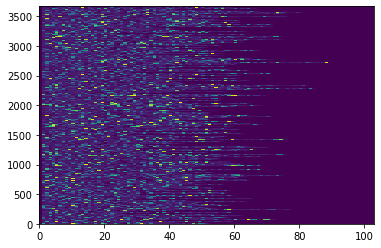

In [15]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

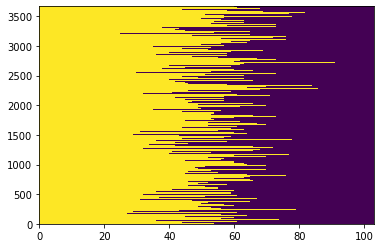

In [16]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

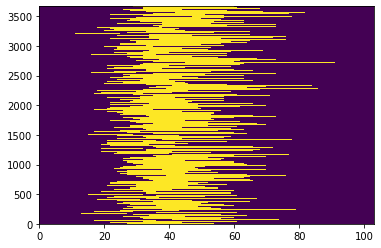

In [17]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [18]:
# create functions


def encode_sentence(s, tokenizer):
  tokens = list(tokenizer.tokenize(s))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)



In [19]:
encode_sentence('this is a sentence', tokenizer)

[2023, 2003, 1037, 6251, 102]

In [20]:
def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [21]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [22]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


## Model

In [23]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [24]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

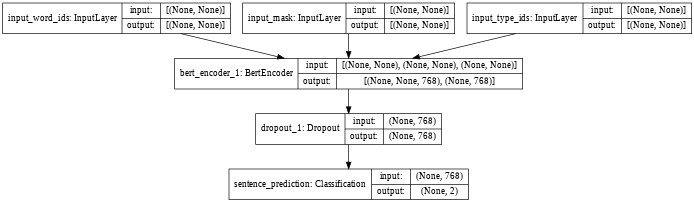

In [25]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [26]:
# run on some training data

glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.11371134, -0.12019665],
       [-0.14002846,  0.04904416],
       [-0.09087281, -0.0021834 ],
       [-0.10669254, -0.20459242],
       [-0.06595843, -0.06851926],
       [-0.18049239,  0.02547483],
       [-0.11831771,  0.0058417 ],
       [-0.02672421, -0.07817787],
       [ 0.05698576,  0.06955832],
       [ 0.03667759, -0.20148623]], dtype=float32)

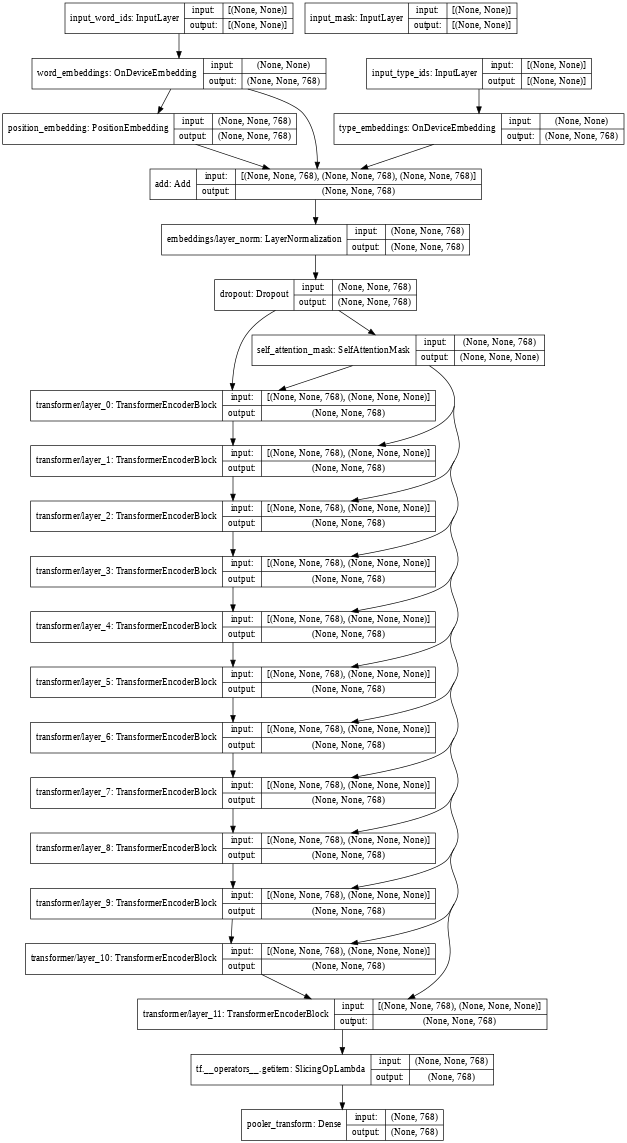

In [27]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [28]:
# Pull weights from checkpoint

checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

## Optimizer

In [29]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [30]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

## Training

In [31]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
115/115 [==============================] - 165s 1s/step - loss: 0.6913 - accuracy: 0.5853 - val_loss: 0.5267 - val_accuracy: 0.7328
Epoch 2/3
115/115 [==============================] - 145s 1s/step - loss: 0.4513 - accuracy: 0.7849 - val_loss: 0.4952 - val_accuracy: 0.7990
Epoch 3/3
115/115 [==============================] - 145s 1s/step - loss: 0.3447 - accuracy: 0.8536 - val_loss: 0.4645 - val_accuracy: 0.8358


In [35]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'CMPE 297 at San Jose State is fun!',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'San Jose State has a fun class called CMPE297',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

In [36]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [34]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent'], dtype='<U14')